# Time Series Anomaly Detection with LSTM Autoencoders

https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/#anomaly-detection


refer this to write about autoencoder
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

view the video 
If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle on Autoencoder. the link is inside this article
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd


https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf

Anomaly Detection with Autoencoders

Here are the basic steps to Anomaly Detection using an Autoencoder:

    Train an Autoencoder on normal data (no anomalies)
    Take a new data point and try to reconstruct it using the Autoencoder
    If the error (reconstruction error) for the new data point is above some threshold, we label the example as an anomaly
    
    Anomaly detection refers to the task of finding and identifying rate events and data point and some applications include bank fraud detection, tumor detection in medical imaging and errors in written text
    
    A lot of supervised and unsuerpvised approaches to anomaly detection has been proposed. Some of the approaches includes one class SVMs, Bayesian networks, cluster analysis and neural networks
    We will use LSTM autoencoder neural netowrk to detect and predict anomalies.
    
    LSTM autoencoders
    Autoencoder neural networks try to learn data representation of its input. So the input of the autoencoder is the same as the output. Usually, we want to learn an efficient encoding that uses fewer parametrs/memory
    
    the encoding should allow for output similar to the original input. In a sense, we are forcing the model to learn the most importatn feature of the data using a few parameters as possible.
    A key attribute of recurrent neural networks is their ability to persist information or cell state for use later in the network. This makes them particularly well suited for analysis of temporal data that evolves over time.
    LSTM netowrks are used in task such as speech recognition, text translation adn here in the analysis of the sequential email traffic for anomaly detection
    
    We will use an autoencoder neural network architecture for our anomaly detection model. The autoencoder architecture essentially learns an identify function. It will take the input data, create a compressed representation of the core/primary driving features of that data and then learn to reconstruct it again.
    For instance, input an image of a dog, it will compress the data down to the core constituents that make up the dog pricture and then learn to recreate the original picture from teh compressed version of the data.
    The rationale for using this architecture for anomaly detection is that we trian the model on the normal data and determine the resulting reconstruction error. Then, when the model encounters data that is outside the norm and attempts to reconstruct it, we will see an increase in the reconstruction error as the model was never trained to accurately recreate items from the outside the norm.
    

In [2]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential

# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

import tensorflow as tf
print("Tensorflow:", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from math import sqrt
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, validation_curve

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

Using TensorFlow backend.


Tensorflow: 2.0.0-alpha0


In [3]:
np.random.seed(1337)

In [4]:
#********Load data**************************

dataset = pd.read_csv('../Paper1/spamkevin.csv', usecols=[0])
dataset.head()

,5568
0,1653
1,1660
2,1592
3,1482
4,6742


In [5]:
dataset.columns = ['Traffic']

In [6]:
dataset.head()

,Traffic
0,1653
1,1660
2,1592
3,1482
4,6742


In [7]:
dataset.isnull().values.any()

False

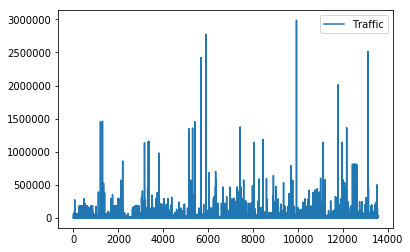

In [8]:

plt.plot(dataset, label='Traffic')
plt.legend()

# data preprocessing

In [9]:

train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)]
print(train.shape, test.shape)

(12866, 1) (678, 1)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Traffic']])

train['Traffic'] = scaler.transform(train[['Traffic']])
test['Traffic'] = scaler.transform(test[['Traffic']])

c:\users\31950627\kerast\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  
c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A v

In [11]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:

TIME_STEPS = 3

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Traffic']], train, TIME_STEPS)
X_test, y_test = create_dataset(test[['Traffic']], test, TIME_STEPS)

print(X_train.shape)

(12863, 3, 1)


# LSTM autoencoder 

In [13]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [14]:
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 11576 samples, validate on 1287 samples
Epoch 1/10
11576/11576 [==============================] - 2s 205us/sample - loss: 0.1999 - val_loss: 0.2517
Epoch 2/10
11576/11576 [==============================] - 2s 134us/sample - loss: 0.1376 - val_loss: 0.2022
Epoch 3/10
11576/11576 [==============================] - 2s 136us/sample - loss: 0.1186 - val_loss: 0.1723
Epoch 4/10
11576/11576 [==============================] - 2s 137us/sample - loss: 0.1102 - val_loss: 0.1553
Epoch 5/10
11576/11576 [==============================] - 2s 139us/sample - loss: 0.0979 - val_loss: 0.1071
Epoch 6/10
11576/11576 [==============================] - 2s 147us/sample - loss: 0.0658 - val_loss: 0.0679
Epoch 7/10
11576/11576 [==============================] - 2s 137us/sample - loss: 0.0554 - val_loss: 0.0499
Epoch 8/10
11576/11576 [==============================] - 2s 136us/sample - loss: 0.0476 - val_loss: 0.0485
Epoch 9/10
11576/11576 [==============================] - 2s 140us/sample - loss: 0.044

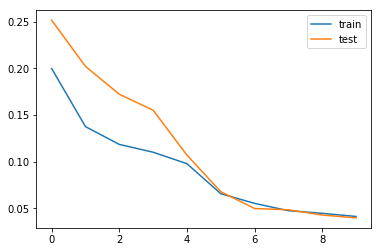

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# Loss distribution

# Finding anomalies

In [16]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

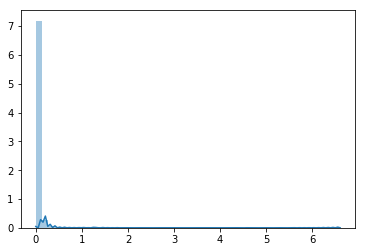

In [17]:
#lets look at the error
sns.distplot(train_mae_loss, bins=50, kde=True);

In [18]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [19]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Traffic'] = test[TIME_STEPS:]

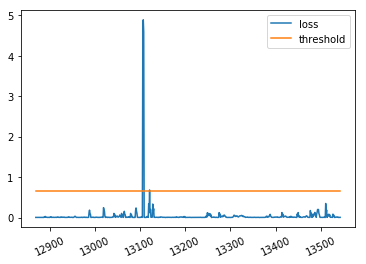

In [20]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

Looks like in the above figure, we are thresholding the extreme values quite well. Lets create a dataframe using only those

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Traffic
13106,4.695428,0.65,True,-0.249918
13107,4.890409,0.65,True,-0.260846
13108,4.589173,0.65,True,-0.164534
13121,0.681232,0.65,True,-0.259516


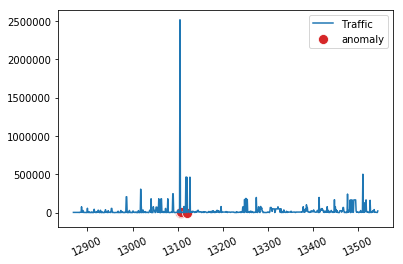

In [22]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].Traffic), 
  label='Traffic'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.Traffic),
  color=sns.color_palette()[3],
  s=100,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

# Prediction and Reconstruction error

In [23]:
test_x_predictions = model.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame(data=np.concatenate((mse, y_test), axis=1), columns=["Reconstruction_error", "True_class"])
error_df.describe()

,Reconstruction_error,True_class
count,6.750000e+02,675.000000
mean,2.626237e-01,0.013152
std,3.871946e+00,1.163455
min,2.150723e-07,-0.264039
25%,1.348383e-05,-0.235382
50%,4.305610e-05,-0.198064
75%,3.653557e-04,-0.092218
max,6.122636e+01,26.474006


In [24]:
error_df.head()

,Reconstruction_error,True_class
0,0.000008,-0.230530
1,0.000008,-0.230530
2,0.000008,-0.230168
3,0.000008,-0.230892
4,0.000008,-0.230828


In [25]:
print(X_test.shape)
print(y_test.shape)

(675, 3, 1)
(675, 1)


In [26]:
#cutoff = 0.7                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(mse)    # initialise a matrix full with zeros
y_pred_classes[mse > THRESHOLD] = 1 

In [27]:
y_test_classes = np.zeros_like(y_test)
y_test_classes[y_test > THRESHOLD] = 1

In [28]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_classes, y_pred_classes)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94791667 0.        ]
recall: [0.9953125 0.       ]
fscore: [0.97103659 0.        ]
support: [640  35]


# Confusion matrix

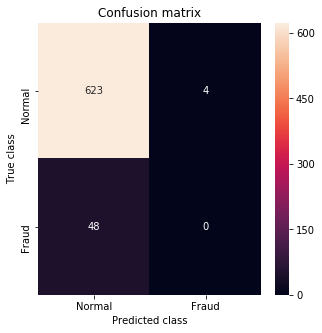

In [31]:
# Confusion Matrix
LABELS = ["Normal", "Fraud"]
threshold = 0.5
error_df["pred_anomaly"] = (error_df["Reconstruction_error"]>threshold).astype(int)
error_df["true_anomaly"] = (error_df["True_class"]>threshold).astype(int)
conf_matrix = confusion_matrix(error_df["true_anomaly"], error_df["pred_anomaly"])

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS,annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



In [32]:
test_x_predictions = model.predict(X_test)
y_pred = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)

In [33]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import  precision_score

In [57]:
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score
import sklearn
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

# calculate prediction
#precision = f1_score(y_test, y_pred, average='binary')
#print('F-Measure: %.3f' % precision)

15.717234398082795


In [58]:
def rmse(y_act, y_pred):
    """
    metrics rmse = Root Mean Squared Error (regression only)

    :param y_act: vector of actual values
    :param y_pred: vector of predicted values
    :return: rmse
    """
    return math.sqrt(sklearn.metrics.mean_squared_error(y_act, y_pred)) 

In [59]:
RMSE= rmse(y_test, y_pred)
print(RMSE)

3.9644967395727284


# ROC

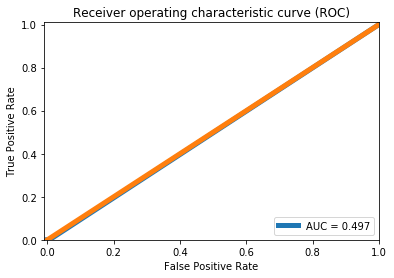

In [35]:
false_pos_rate, true_pos_rate, THRESHOLD = roc_curve(error_df["true_anomaly"], error_df["pred_anomaly"])
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Recall vs Precision thresholding

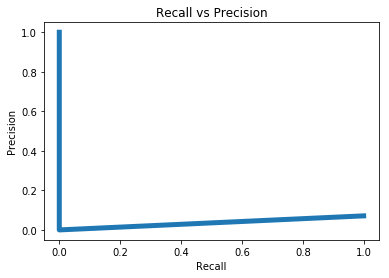

In [36]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df['true_anomaly'], error_df['pred_anomaly'])
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

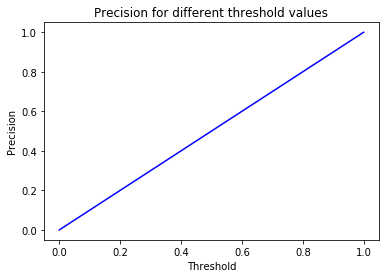

In [37]:
plt.plot(threshold_rt, precision_rt[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

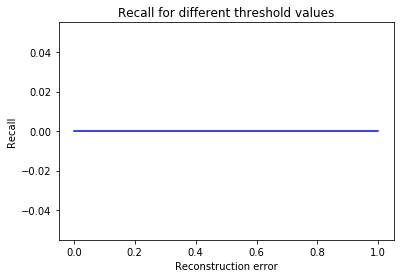

In [38]:
plt.plot(threshold_rt, recall_rt[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

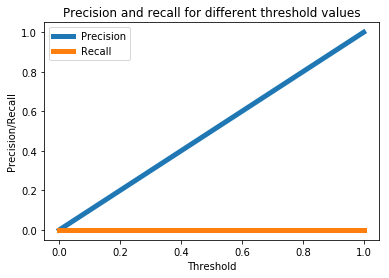

In [39]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Reconstruction error vs threshold check

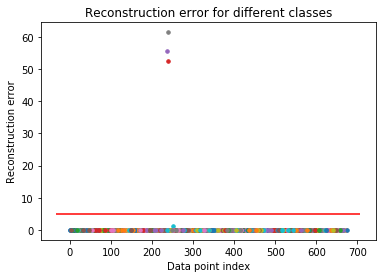

In [40]:
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

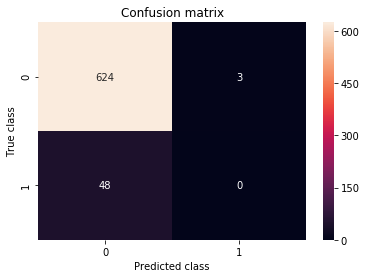

In [41]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error']]
conf_matrix = confusion_matrix(error_df['true_anomaly'], pred_y)

#plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Prediction

In [42]:
threshold = 2.9

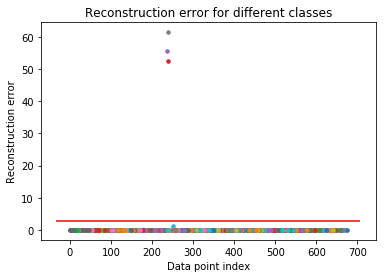

In [43]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.legend()
plt.show()


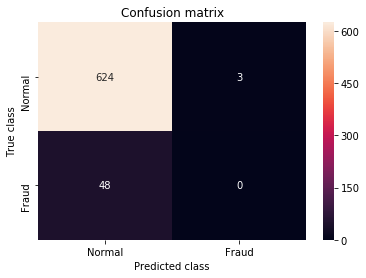

In [44]:
LABELS = ["Normal", "Fraud"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error']]
conf_matrix = confusion_matrix(error_df['true_anomaly'], pred_y)

#plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix,xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()